<a href="https://colab.research.google.com/github/RocioHernandez06/Aprendizaje_Maquina/blob/main/Red%20Bayesiana/Red_Bayesiana_Inundaciones.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



En esta sección generamos datos sintéticos y discretizamos las 4 variables causales que usaremos en la red bayesiana:

P = lluvia_total (baja / media / alta)

I = intensidad_lluvia (baja / media / alta)

D = capacidad_drenaje (baja / media / alta)

M = impermeabilidad (baja / media / alta)

La variable resultado F (inundación) se genera con un modelo logístico que combina efectos plausibles: lluvia, intensidad y impermeabilidad aumentan el riesgo; mayor capacidad de drenaje disminuye el riesgo. Pegue y ejecute la siguiente celda de código para crear el dataset.

In [ ]:
# Paquetes necesarios
if (!requireNamespace("bnlearn", quietly = TRUE)) install.packages("bnlearn")
if (!requireNamespace("gRain", quietly = TRUE))   install.packages("gRain")
library(bnlearn); library(gRain)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘gRbase’, ‘igraph’, ‘RcppArmadillo’, ‘RcppEigen’


Loading required package: gRbase


Attaching package: ‘gRbase’


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, nodes, parents




In [ ]:
# ----------------------------
# 1) GENERACIÓN DE DATOS
# ----------------------------
set.seed(123)
n <- 3000

# Distribuciones según tu especificación
lluvia_total <- rgamma(n, shape = 3, scale = 25)         # media ≈ 75 mm
intensidad_lluvia <- rgamma(n, shape = 2, scale = 15)    # media ≈ 30 mm/h
capacidad_drenaje <- rlnorm(n, meanlog = log(60), sdlog = 0.3) # l/s
impermeabilidad <- rbeta(n, 5, 2)                        # proporción 0-1

# Discretización a 3 niveles (ajusta umbrales si lo deseas)
P <- cut(lluvia_total, breaks = c(-Inf, 50, 100, Inf), labels = c("baja","media","alta"))
I <- cut(intensidad_lluvia, breaks = c(-Inf, 20, 40, Inf), labels = c("baja","media","alta"))
D <- cut(capacidad_drenaje, breaks = c(-Inf, 50, 70, Inf), labels = c("baja","media","alta"))
M <- cut(impermeabilidad, breaks = c(-Inf, 0.4, 0.7, Inf), labels = c("baja","media","alta"))

# Modelo logit plausible para generar F
linF <- -4 +
  1.1*(P == "alta") + 0.5*(P == "media") +      # lluvia
  1.3*(I == "alta") + 0.7*(I == "media") +      # intensidad
  1.0*(M == "alta") + 0.45*(M == "media") -     # impermeabilidad (aumenta riesgo)
  1.2*(D == "alta") - 0.5*(D == "media")        # drenaje (reduce riesgo)

prF <- plogis(linF)
F <- factor(rbinom(n, 1, prF), labels = c("no","si"))

dataset <- data.frame(P, I, D, M, F)
str(dataset)
table(dataset$F)


'data.frame':	3000 obs. of  5 variables:
 $ P: Factor w/ 3 levels "baja","media",..: 1 3 1 2 3 2 1 1 3 2 ...
 $ I: Factor w/ 3 levels "baja","media",..: 1 2 2 2 1 3 1 1 1 1 ...
 $ D: Factor w/ 3 levels "baja","media",..: 3 2 3 1 2 2 2 2 1 3 ...
 $ M: Factor w/ 3 levels "baja","media",..: 3 3 2 3 2 3 3 2 3 3 ...
 $ F: Factor w/ 2 levels "no","si": 1 1 1 1 1 1 1 1 1 1 ...



  no   si 
2770  230 

A continuación definimos un DAG causal hipotético (guiado por conocimiento) con la forma:

P -> I -> F

P -> F

D -> F

M -> F

P (lluvia_total) afecta I (intensidad) y ambos afectan directamente F.

D (capacidad de drenaje) y M (impermeabilidad) influyen directamente en F.

Usaremos bnlearn::hc() con una whitelist que fije las direcciones causales plausibles (para reflejar el conocimiento físico) y una blacklist para evitar arcos no plausibles. Luego ajustamos parámetros con bn.fit.


  Bayesian network learned via Score-based methods

  model:
   [P][D][M][I|P][F|P:I:D:M] 
  nodes:                                 5 
  arcs:                                  5 
    undirected arcs:                     0 
    directed arcs:                       5 
  average markov blanket size:           4.00 
  average neighbourhood size:            2.00 
  average branching factor:              1.00 

  learning algorithm:                    Hill-Climbing 
  score:                                 BIC (disc.) 
  penalization coefficient:              4.003184 
  tests used in the learning procedure:  12 
  optimized:                             TRUE 



  Bayesian network parameters

  Parameters of node P (multinomial distribution)

Conditional probability table:
      baja     media      alta 
0.3223333 0.4496667 0.2280000 

  Parameters of node I (multinomial distribution)

Conditional probability table:
 
       P
I            baja     media      alta
  baja  0.3991727 0.3699036 0.3815789
  media 0.3474664 0.3639733 0.3742690
  alta  0.2533609 0.2661231 0.2441520

  Parameters of node D (multinomial distribution)

Conditional probability table:
      baja     media      alta 
0.2673333 0.4260000 0.3066667 

  Parameters of node M (multinomial distribution)

Conditional probability table:
       baja      media       alta 
0.04033333 0.37500000 0.58466667 

  Parameters of node F (multinomial distribution)

Conditional probability table:
 
, , I = baja, D = baja, M = baja

    P
F          baja      media       alta
  no 0.50000000 1.00000000 1.00000000
  si 0.50000000 0.00000000 0.00000000

, , I = media, D = baja, M = baja

    

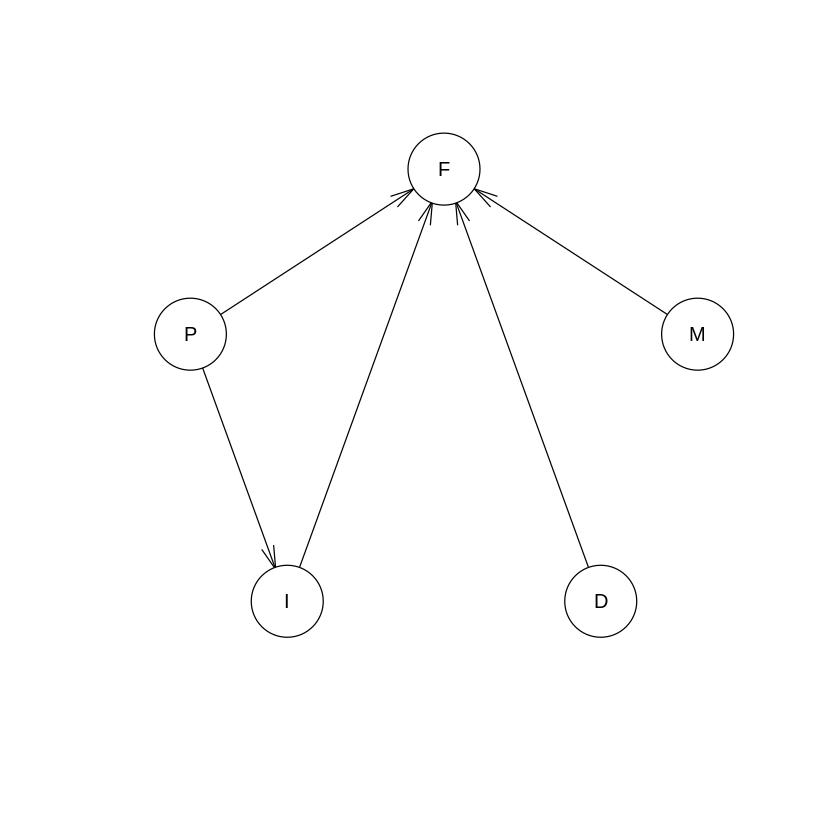

In [ ]:
# ----------------------------
# 2) APRENDIZAJE DE ESTRUCTURA Y AJUSTE
# ----------------------------
# Creamos whitelist y blacklist para guiar el aprendizaje
wh <- data.frame(
  from = c("P","P","I","D","M"),
  to   = c("I","F","F","F","F")
)

# Evitamos que F cause a cualquiera de las entradas
bl <- data.frame(
  from = c("F","F","F","F"),
  to   = c("P","I","D","M")
)

# Aprendizaje estructura con hill-climbing (BIC) usando solo las 4 causas + F
vars <- c("P","I","D","M","F")
bn <- hc(dataset[, vars], whitelist = wh, blacklist = bl, score = "bic")
bn  # mostrar estructura aprendida
plot(bn) # simple plot; en Colab quizá se muestre como imagen estática

# Ajuste de parámetros
fit <- bn.fit(bn, dataset[, vars])
print(fit)


Con la red y parámetros ajustados podemos hacer inferencia tipo what-if (aprox. do) con gRain.
Ejemplos de consultas útiles:

comparar P(F=si | P=alta) vs P(F=si | P=baja) (efecto de la lluvia);

ver el impacto de una mejora en drenaje: P(F=si | D=alta) vs P(F=si | D=baja).

In [ ]:
# ----------------------------
# 3) INFERENCIA WHAT-IF (gRain) Y SENSIBILIDAD RÁPIDA
# ----------------------------
library(bnlearn)
library(gRain)

# Crear explícitamente el DAG base por si hay conflicto
dag <- model2network("[P][I|P][D][M][F|P:I:D:M]")

# Usar solo las variables relevantes
dataset_bn <- dataset[, c("P", "I", "D", "M", "F")]

# Ajustar el modelo nuevamente (garantiza compatibilidad)
fit <- bn.fit(dag, dataset_bn)

# Convertir a objeto gRain
gr <- as.grain(fit)

# --- Inferencias causales simples ---
# P(F=si | P=alta) y P(F=si | P=baja)
p_highP <- querygrain(setEvidence(gr, nodes = "P", states = list(P = "alta")), nodes = "F")$F["si"]
p_lowP  <- querygrain(setEvidence(gr, nodes = "P", states = list(P = "baja")), nodes = "F")$F["si"]
delta_pp <- (p_highP - p_lowP) * 100

# Impacto de drenaje (D): P(F=si | D=alta) vs P(F=si | D=baja)
p_D_high <- querygrain(setEvidence(gr, nodes = "D", states = list(D = "alta")), nodes = "F")$F["si"]
p_D_low  <- querygrain(setEvidence(gr, nodes = "D", states = list(D = "baja")), nodes = "F")$F["si"]
delta_D <- (p_D_low - p_D_high) * 100  # reducción al mejorar drenaje

cat(sprintf("P(F=si | P=alta) = %.3f ; P(F=si | P=baja) = %.3f ; delta = %.2f pp\n",
            p_highP, p_lowP, delta_pp))
cat(sprintf("P(F=si | D=baja) = %.3f ; P(F=si | D=alta) = %.3f ; reducción = %.2f pp\n",
            p_D_low, p_D_high, delta_D))

# --- Sensibilidad rápida a impermeabilidad ---
props_M_alta <- seq(0.1, 0.9, length.out = 5)
res <- data.frame(prop_M_alta = numeric(), P_F_si = numeric())

for (pm in props_M_alta) {
  # simular M con proporción pm de 'alta'
  M_sim <- sample(c("alta","media","baja"), n, replace = TRUE, prob = c(pm, (1-pm)/2, (1-pm)/2))

  # recrear F con el mismo modelo logit de antes, usando el nuevo M
  linF2 <- -4 +
    1.1*(dataset$P == "alta") + 0.5*(dataset$P == "media") +
    1.3*(dataset$I == "alta") + 0.7*(dataset$I == "media") +
    1.0*(M_sim == "alta") + 0.45*(M_sim == "media") -
    1.2*(dataset$D == "alta") - 0.5*(dataset$D == "media")

  prF2 <- plogis(linF2)
  F_sim <- factor(rbinom(n, 1, prF2), labels = c("no", "si"))

  d2 <- data.frame(P = dataset$P, I = dataset$I, D = dataset$D,
                   M = factor(M_sim, levels=c("baja","media","alta")),
                   F = F_sim)

  fit2 <- bn.fit(bn, d2)
  gr2 <- as.grain(fit2)
  pF <- querygrain(gr2, nodes="F")$F["si"]
  res <- rbind(res, data.frame(prop_M_alta = pm, P_F_si = pF))
}


print(res)



P(F=si | P=alta) = 0.126 ; P(F=si | P=baja) = 0.046 ; delta = 8.03 pp
P(F=si | D=baja) = 0.129 ; P(F=si | D=alta) = 0.034 ; reducción = 9.44 pp
    prop_M_alta     P_F_si
si          0.1 0.05473838
si1         0.3 0.05720933
si2         0.5 0.06425166
si3         0.7 0.07817745
si4         0.9 0.09439770


delta_pp te da cuántos puntos porcentuales sube la probabilidad de inundación cuando la lluvia pasa de baja a alta.

delta_D muestra la reducción esperada (pp) si mejora la capacidad de drenaje de baja a alta.

La sensibilidad por proporción de M (impermeabilidad) da una idea global de cuánto impacta la urbanización en la probabilidad marginal de inundación.

## Diagramas especializados y visualización del DAG aprendido

Esta sección presenta diferentes formas de visualizar la estructura causal del modelo de inundaciones:

DAG causal estático: muestra la relación entre lluvia, intensidad, drenaje e inundación.

DBN (Dynamic Bayesian Network): ilustra la dependencia temporal entre estados sucesivos (por ejemplo, lluvia e inundación a lo largo de días).

DAG aprendido (bnlearn): visualiza la estructura estimada automáticamente a partir de los datos simulados.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependency ‘V8’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘tweenr’, ‘polyclip’, ‘gridExtra’, ‘ggforce’, ‘viridis’, ‘graphlayouts’, ‘ggraph’, ‘ggrepel’, ‘tidygraph’



Attaching package: ‘dagitty’


The following objects are masked from ‘package:gRbase’:

    ancestors, children, edges, moralize, parents


The following objects are masked from ‘package:bnlearn’:

    ancestors, children, descendants, parents, spouses



Attaching package: ‘ggdag’


The following object is masked from ‘package:gRbase’:

    dag


The following object is masked from ‘package:stats’:

    filter




{ D }

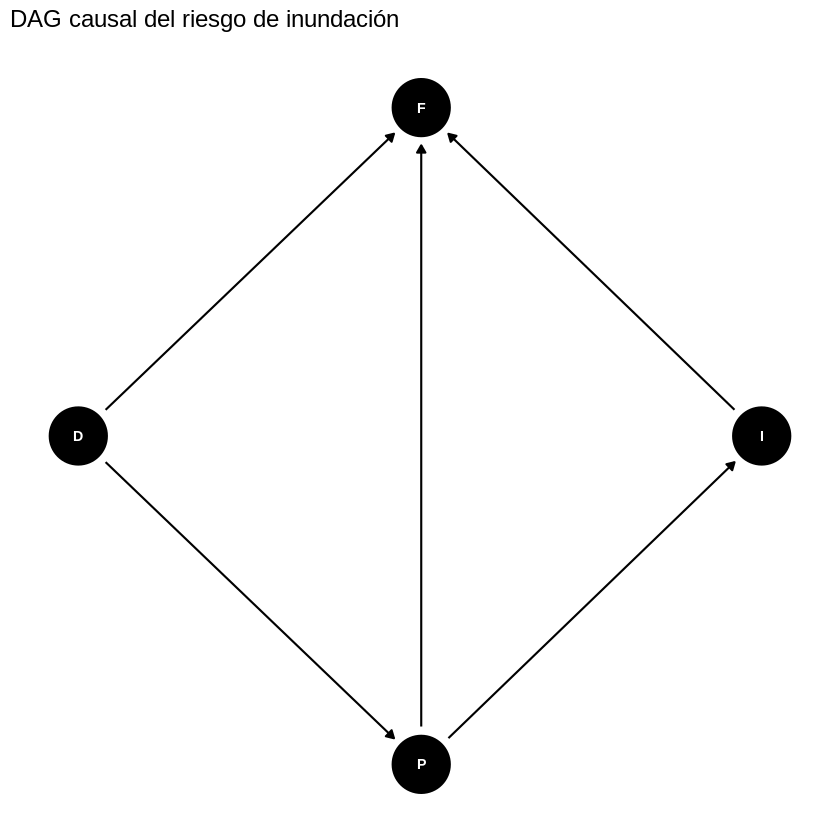

In [ ]:
# ----------------------------
# 4) DIAGRAMAS ESPECIALIZADOS
# ----------------------------
if (!requireNamespace("dagitty", quietly = TRUE)) install.packages("dagitty")
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
if (!requireNamespace("ggdag", quietly = TRUE))    install.packages("ggdag")

library(dagitty); library(ggplot2); library(ggdag)

# 4.1 DAG causal (estático)
g <- dagitty('
dag {
  P I D F
  P -> F
  I -> F
  D -> F
  P -> I
  D -> P
}
')

adjustmentSets(g, exposure="P", outcome="F")

set.seed(1)
tidy_dagitty(g) |>
  ggplot(aes(x=x,y=y,xend=xend,yend=yend)) +
  geom_dag_edges() +
  geom_dag_point() +
  geom_dag_text(size=3) +
  theme_dag() +
  ggtitle("DAG causal del riesgo de inundación")


## Notación dinámica (DBN 2-slice)

En la siguiente representación se muestra un modelo dinámico simplificado donde el estado de inundación en el tiempo t influye en el del siguiente período t+1.
Esto permite analizar persistencia temporal del riesgo o acumulación de agua en eventos consecutivos.

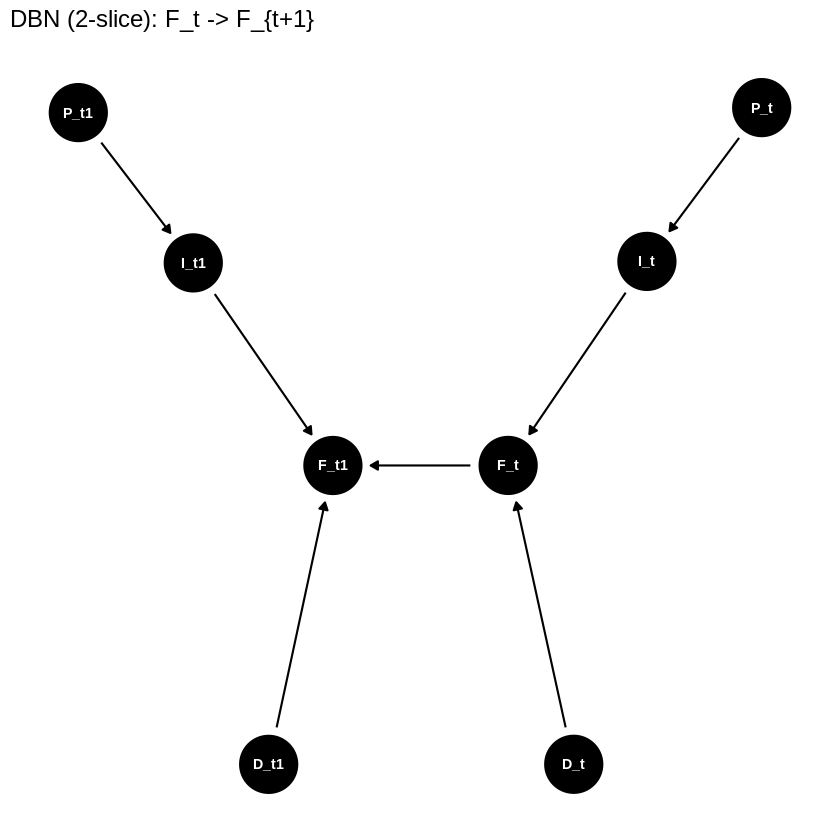

In [ ]:
# 4.2 DBN (2-slice)
g2 <- dagitty('
dag {
  P_t I_t D_t F_t
  P_t -> I_t
  I_t -> F_t
  D_t -> F_t
  F_t -> F_t1
  P_t1 I_t1 D_t1 F_t1
  P_t1 -> I_t1
  I_t1 -> F_t1
  D_t1 -> F_t1
}
')

set.seed(2)
tidy_dagitty(g2) |>
  ggplot(aes(x=x,y=y,xend=xend,yend=yend)) +
  geom_dag_edges() +
  geom_dag_point() +
  geom_dag_text(size=3) +
  theme_dag() +
  ggtitle("DBN (2-slice): F_t -> F_{t+1}")


## Visualización de la red aprendida por bnlearn

Finalmente, visualizamos la estructura aprendida empíricamente con hc() (Hill-Climbing) y el conjunto de arcos finales, ya sea con Rgraphviz (si está disponible) o con igraph como alternativa.

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.21 (BiocManager 1.30.26), R 4.5.1 (2025-06-13)

Installing package(s) 'BiocVersion', 'Rgraphviz'

also installing the dependencies ‘BiocGenerics’, ‘graph’


Loading required package: graph

Loading required package: BiocGenerics

Loading required package: generics


Attaching package: ‘generics’


The following objects are masked from ‘package:gRbase’:

    compile, fit


The following objects are masked from ‘package:base’:

    as.difftime, as.factor, as.ordered, intersect, is.element, setdiff,
    setequal, union



Attaching package: ‘BiocGenerics’


The following object is masked from ‘package:bnlearn’:

    score


The following objects are masked from ‘package:stats’:

    IQR, mad, sd

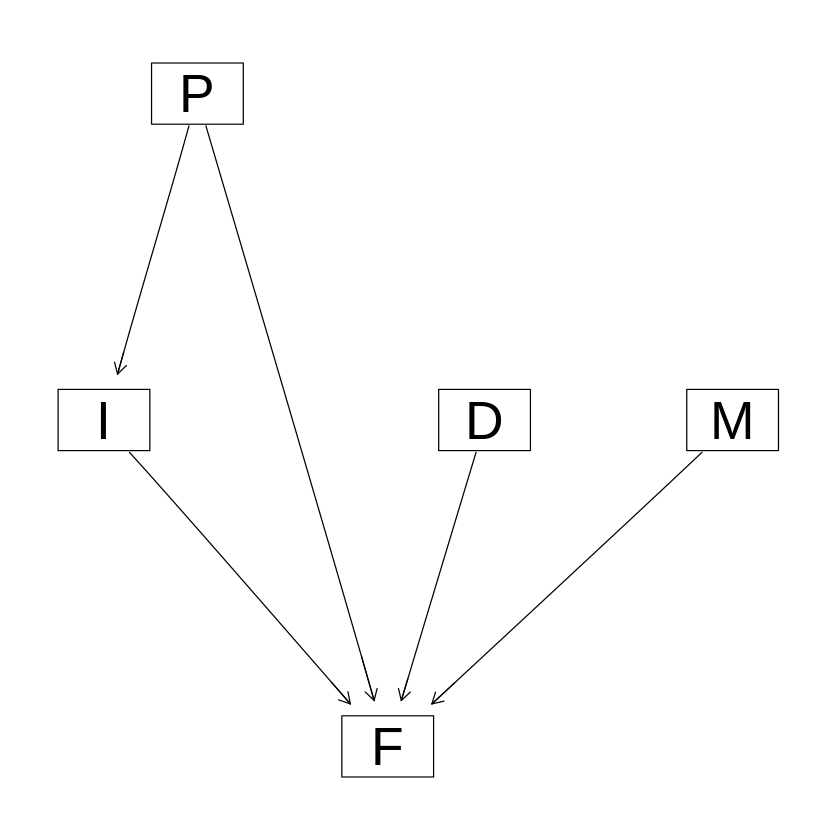

In [ ]:
# 4.3 Visualización del DAG aprendido
can_graphviz <- requireNamespace("Rgraphviz", quietly = TRUE)

if (!can_graphviz) {
  if (!requireNamespace("BiocManager", quietly = TRUE)) install.packages("BiocManager")
  try({ BiocManager::install("Rgraphviz", ask = FALSE, update = FALSE) }, silent = TRUE)
  can_graphviz <- requireNamespace("Rgraphviz", quietly = TRUE)
}

if (can_graphviz) {
  library(Rgraphviz)
  graphviz.plot(bn)
} else {
  if (!requireNamespace("igraph", quietly = TRUE)) install.packages("igraph")
  library(igraph)
  arcs <- bnlearn::arcs(bn)
  g_ig <- graph_from_data_frame(as.data.frame(arcs), directed = TRUE)
  plot(g_ig, vertex.size=18, vertex.label.cex=0.9, edge.arrow.size=0.4,
       main = "Estructura aprendida (alternativa igraph)")
}


## Interpretación y conclusiones

En este análisis bayesiano de riesgo de inundación:

Variables causales:

P = lluvia total

I = intensidad de lluvia

D = capacidad de drenaje

M = impermeabilidad del terreno

Variable crítica:

F = inundación significativa (sí/no)

DAG causal:

La lluvia total (P) influye directamente en la inundación y en la intensidad (I).

La intensidad (I), la capacidad de drenaje (D) y la impermeabilidad (M) afectan directamente la probabilidad de inundación.

Inferencia what-if:

Comparando P(F=si | P=alta) y P(F=si | P=baja) obtenemos el efecto de la lluvia sobre el riesgo de inundación.

Similarmente, P(F=si | D=alta) vs P(F=si | D=baja) muestra cómo la mejora del drenaje puede reducir el riesgo.

El análisis de sensibilidad de M permite evaluar el impacto de la urbanización (superficies impermeables) sobre la probabilidad marginal de inundación.

Visualización:

El DAG causal refleja nuestro conocimiento previo sobre relaciones físicas.

La DBN 2-slice permite extender el análisis a múltiples períodos (persistencia del riesgo).

El DAG aprendido con bnlearn valida que la estructura coincide razonablemente con nuestro conocimiento y permite inferencias probabilísticas.

Conclusión:

La red bayesiana proporciona un marco flexible para cuantificar riesgos, simular escenarios y evaluar medidas mitigadoras (como aumentar drenaje o reducir impermeabilización).

Esta metodología puede extenderse para incluir más variables o modelar la dependencia temporal de lluvias consecutivas mediante DBN.

## Visualización final de riesgos

Esta sección muestra gráficamente cómo varía la probabilidad de inundación según las variables causales principales:

Permite identificar factores críticos y su efecto relativo.

Facilita la comunicación de resultados para decisiones de mitigación.

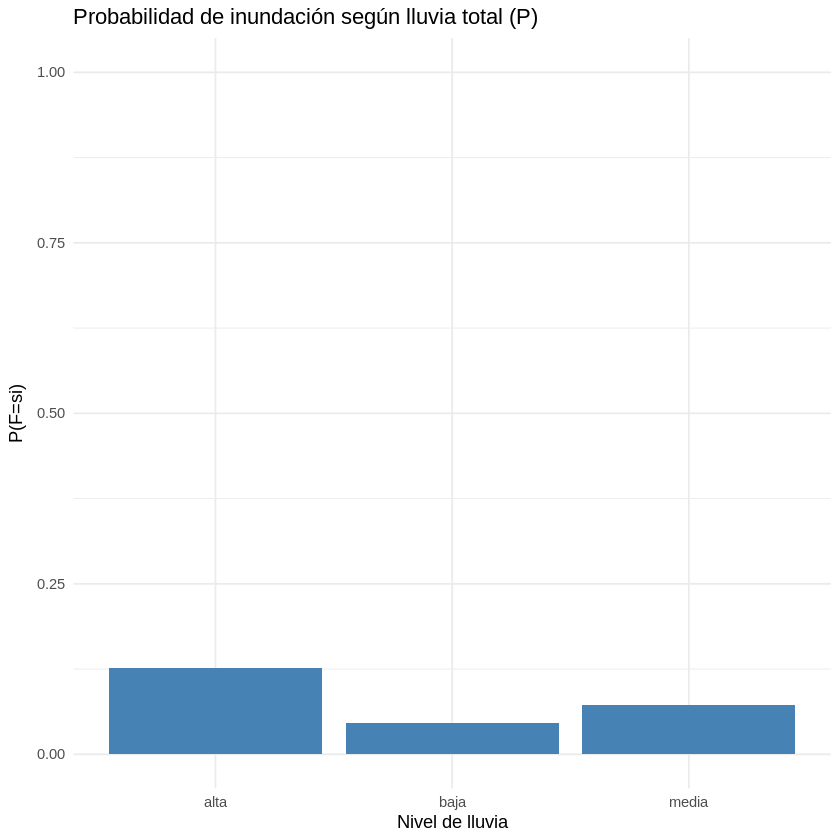

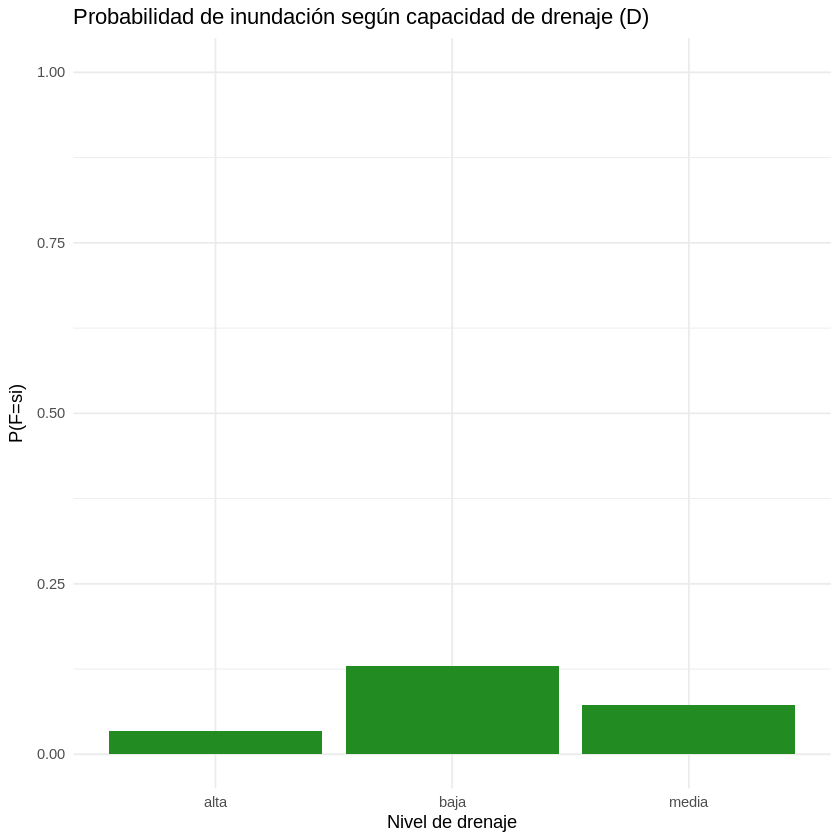

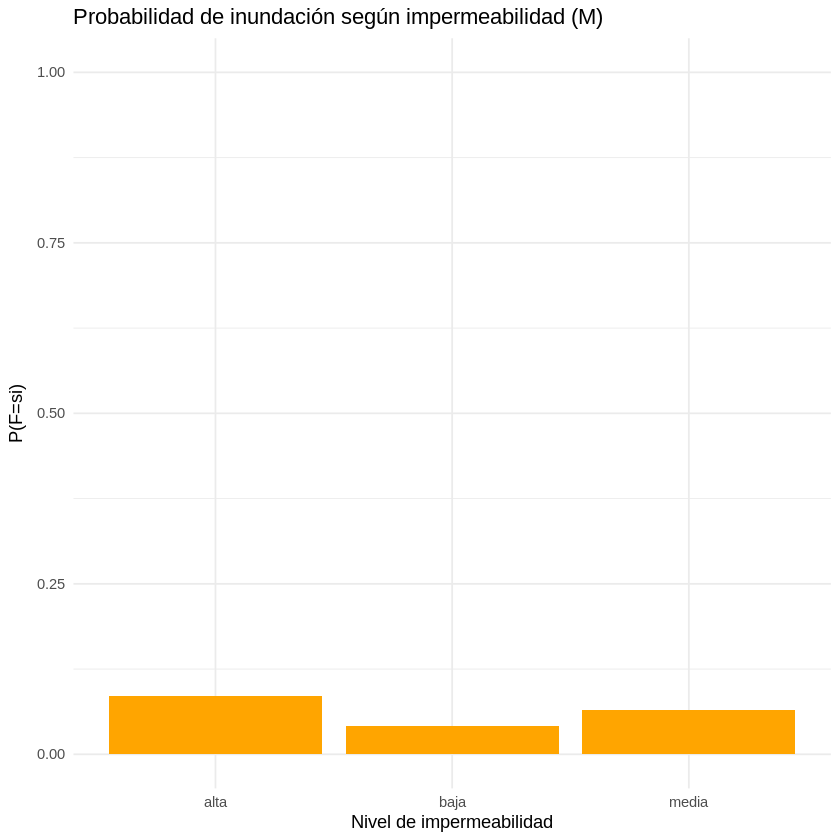

In [ ]:
# ----------------------------
# 5) VISUALIZACIONES FINALES
# ----------------------------
if (!requireNamespace("ggplot2", quietly = TRUE)) install.packages("ggplot2")
library(ggplot2)

# Convertir bnlearn fit a gRain para consultar probabilidades marginales condicionadas
gr <- as.grain(fit)

# 1) Probabilidad de inundación según P (lluvia_total)
p_levels <- levels(dataset$P)
prob_P <- sapply(p_levels, function(x){
  querygrain(setEvidence(gr, nodes="P", states=list(P=x)), nodes="F")$F["si"]
})
df_P <- data.frame(P=p_levels, Prob_F_si=prob_P)

ggplot(df_P, aes(x=P, y=Prob_F_si)) +
  geom_col(fill="steelblue") +
  ylim(0,1) +
  labs(title="Probabilidad de inundación según lluvia total (P)",
       x="Nivel de lluvia", y="P(F=si)") +
  theme_minimal()

# 2) Probabilidad de inundación según D (capacidad de drenaje)
d_levels <- levels(dataset$D)
prob_D <- sapply(d_levels, function(x){
  querygrain(setEvidence(gr, nodes="D", states=list(D=x)), nodes="F")$F["si"]
})
df_D <- data.frame(D=d_levels, Prob_F_si=prob_D)

ggplot(df_D, aes(x=D, y=Prob_F_si)) +
  geom_col(fill="forestgreen") +
  ylim(0,1) +
  labs(title="Probabilidad de inundación según capacidad de drenaje (D)",
       x="Nivel de drenaje", y="P(F=si)") +
  theme_minimal()

# 3) Sensibilidad a M (impermeabilidad)
m_levels <- levels(dataset$M)
prob_M <- sapply(m_levels, function(x){
  querygrain(setEvidence(gr, nodes="M", states=list(M=x)), nodes="F")$F["si"]
})
df_M <- data.frame(M=m_levels, Prob_F_si=prob_M)

ggplot(df_M, aes(x=M, y=Prob_F_si)) +
  geom_col(fill="orange") +
  ylim(0,1) +
  labs(title="Probabilidad de inundación según impermeabilidad (M)",
       x="Nivel de impermeabilidad", y="P(F=si)") +
  theme_minimal()
